In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
from keras.saving import load_model
from os import path
import sklearn.preprocessing as prep
from librosa.feature import mfcc, delta

In [6]:
def get_patients_SpO2(plist):
    def get_patient(patientid):
        rec = np.load(path.join("numpy", f"SpO2_patient_{patientid}.npy"))
        ann = np.load(path.join("numpy", f"SpO2_annotation_{patientid}.npy"))
        
        return rec, ann
    X, y = get_patient(plist[0])
    siglen = len(y)
    plist = plist[1::]
    for i in plist:
        rec, ann = get_patient(i)
        X = np.hstack((X, rec))
        y = np.hstack((y, ann))
        siglen += len(ann)
    
    X = np.array(np.split(X, siglen, axis=0))
    X = np.array([rec.T for rec in X])
    return X, y

def get_patients_ECG(plist):
    scaler = prep.MinMaxScaler()
    def get_patient(patientid):
        rec = np.load(path.join("numpy", f"patient_{patientid}.npy"))
        ann = np.load(path.join("numpy", f"annotation_{patientid}.npy"))
        return rec, ann

    X, y = get_patient(plist[0])
    siglen = len(y)
    plist = plist[1::]
    for i in plist:
        rec, ann = get_patient(i)
        X = np.hstack((X, rec))
        y = np.hstack((y, ann))
        siglen += len(ann)

    X = np.array(np.split(X, siglen))
    temp = []
    for x in X:
        
        mfccs = mfcc(y=x, sr=100, n_mfcc=24)
        delta1 = delta(mfccs, order=1)
        delta2 = delta(mfccs, order=2)
        data = np.concatenate([mfccs, delta1, delta2])
        temp.append(scaler.fit_transform(data))
    X = np.array(temp)
    X = np.expand_dims(X, 3)
    return X, y

def calc_pred(pred1, pred2, w1, w2):
    pred1 = np.squeeze(pred1)
    pred2 = np.squeeze(pred2)
    res = pred1 * w1 + pred2 * w2
    return (res)

In [7]:

# test data
X_ECG, y_ECG = get_patients_ECG([2])
X_SpO2, y_SpO2 = get_patients_SpO2([2])
# balance
X_ECG = X_ECG[20:len(X_ECG)-20:]
y_ECG = y_ECG[20:len(y_ECG)-20:]

ECG_path = path.join("res", "model_ECG.keras")
SpO2_path = path.join("res", "model_SpO2.keras")

ECG_model = load_model(ECG_path)
SpO2_model = load_model(SpO2_path)

# print(X_ECG.shape, X_SpO2.shape)
pred1 = ECG_model.predict(X_ECG).flatten()
pred2 = SpO2_model.predict(X_SpO2).flatten()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


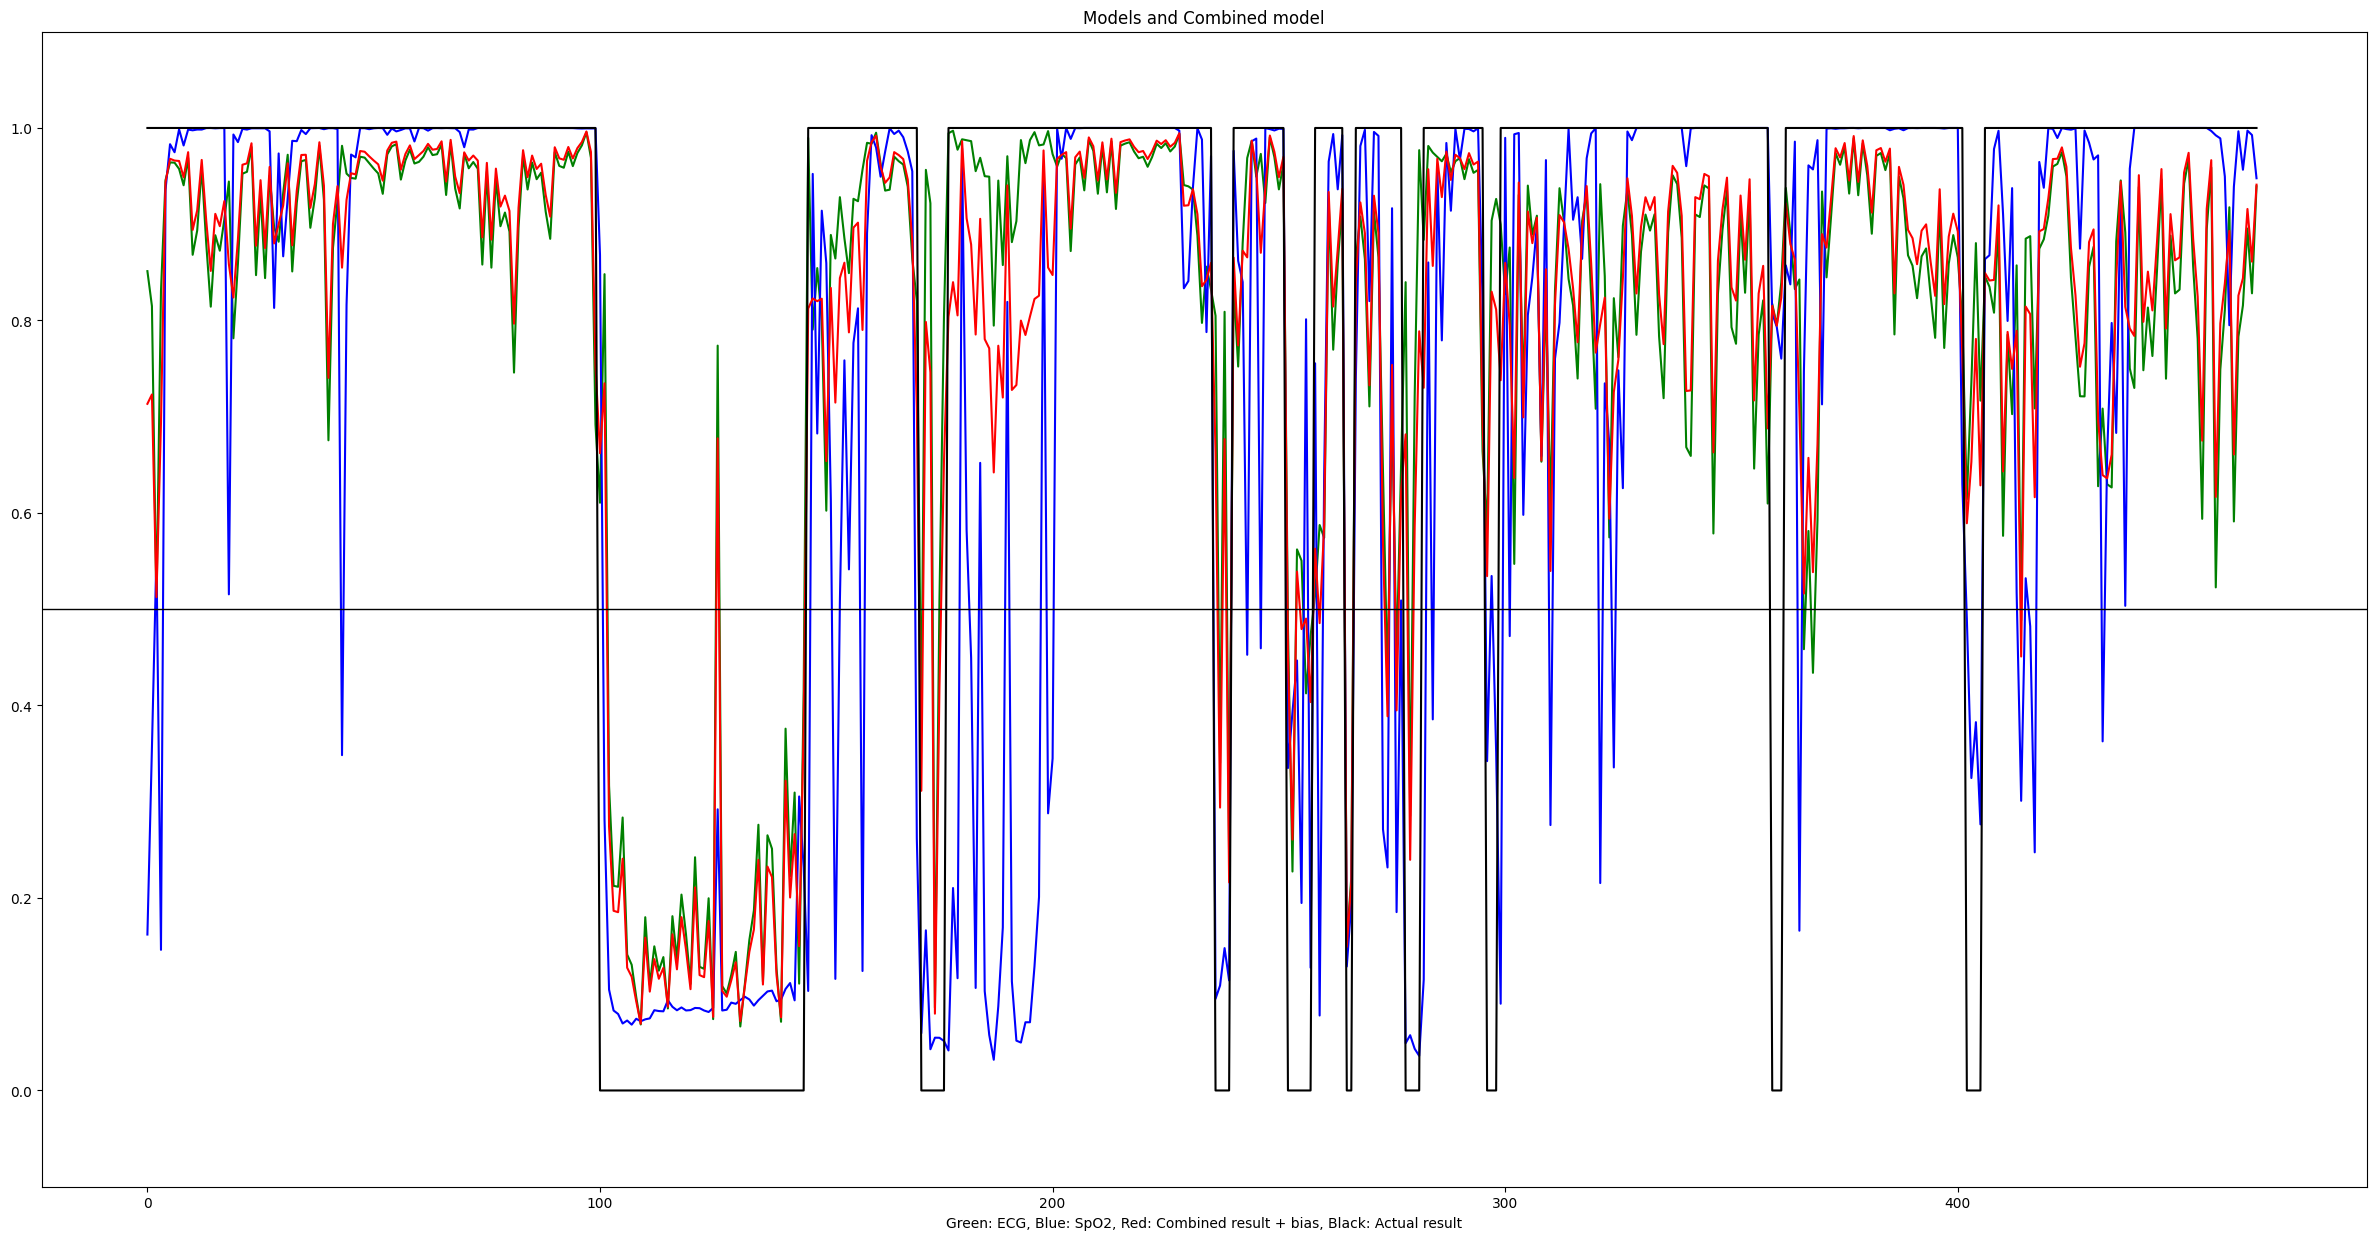

In [9]:
pred = [calc_pred(x, y, 0.8, 0.2) for x, y in zip(pred1, pred2)]

plt.figure(figsize=(30, 15))
plt.ylim(-0.1, 1.1)
plt.title("Models and Combined model")
plt.plot(pred1, color = "g")
plt.plot(pred2, color = "b")
plt.plot(pred, color = "r")
plt.plot(y_SpO2, color = "k")
plt.xlabel("Green: ECG, Blue: SpO2, Red: Combined result + bias, Black: Actual result")
plt.axline((0, 0.5), (len(y_SpO2), 0.5), color="k", linewidth=1)
plt.show()

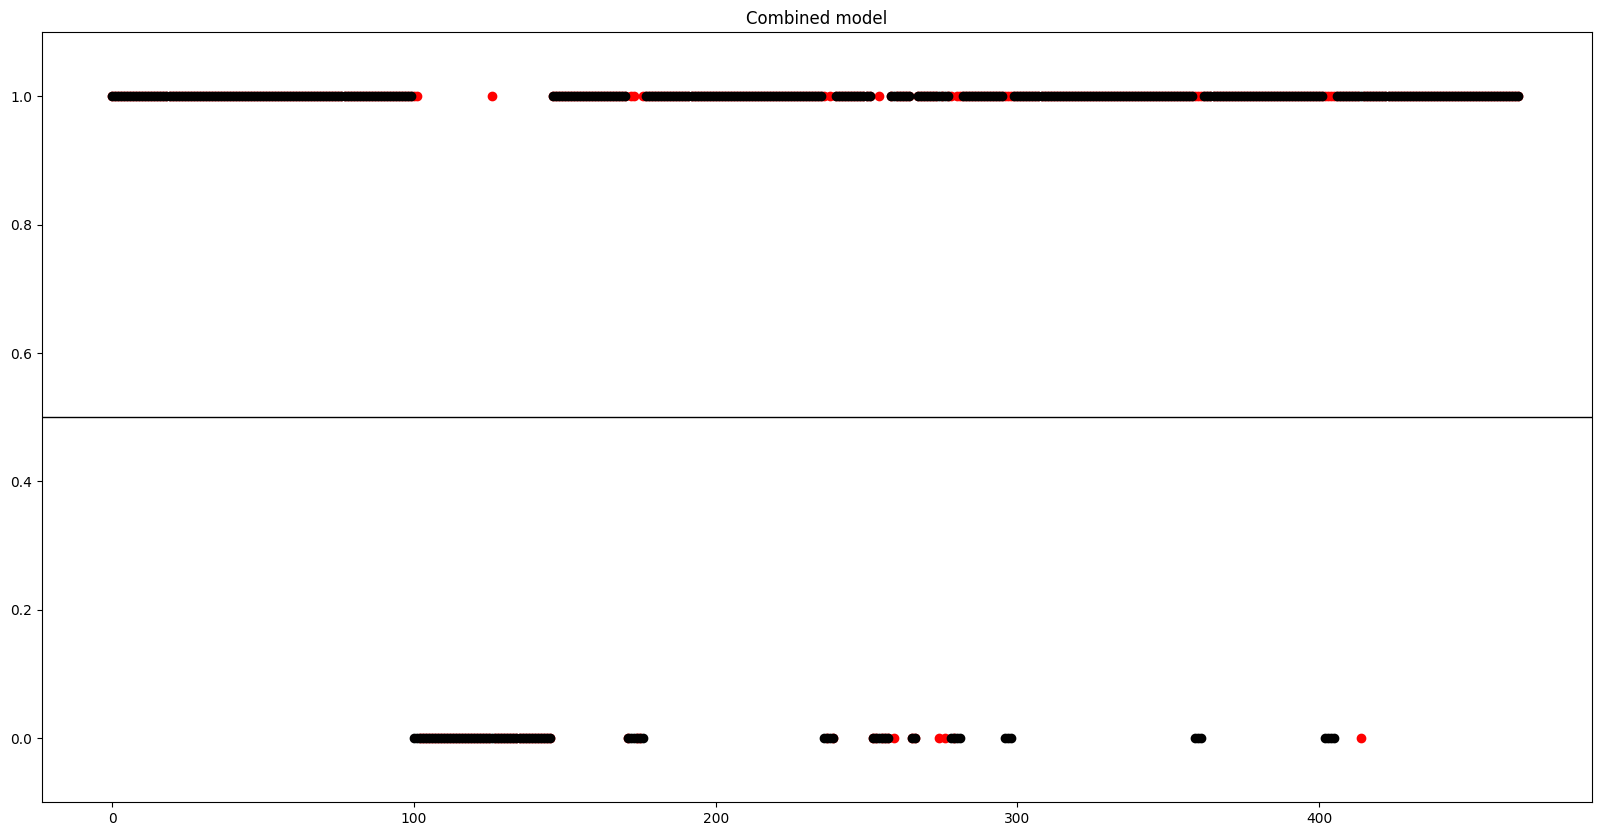

In [11]:
plt.figure(figsize=(20, 10))
plt.ylim(-0.1, 1.1)
plt.title("Combined model")
plt.scatter(range(len(y_SpO2)), [round(x) for x in pred], color = "r")
plt.scatter(range(len(y_SpO2)), y_SpO2, color = "k")
plt.axline((0, 0.5), (len(y_SpO2), 0.5), color="k", linewidth=1)
plt.show()

In [12]:
# test accuracy
X_ECG, y_ECG = get_patients_ECG([1, 2, 3, 4, 21, 26, 27, 28])
X_SpO2, y_SpO2 = get_patients_SpO2(range(1, 9))
# balance
X_ECG = X_ECG[20:len(X_ECG)-20:]
y_ECG = y_ECG[20:len(y_ECG)-20:]

In [13]:
pred1 = ECG_model.predict(X_ECG).flatten()
pred2 = SpO2_model.predict(X_SpO2).flatten()

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [14]:
from keras.metrics import BinaryAccuracy

In [15]:
pred = [calc_pred(x, y, 0.8, 0.2) for x, y in zip(pred1, pred2)]
m = BinaryAccuracy()
m.update_state(y_SpO2, pred)
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.8601096>